Name: Hasan Erdem AK

ID: 181101022

Course: BIL570 / BIL470

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, plot_confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from itertools import cycle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Read Dataset

In [2]:
train_features = pd.read_csv('./training_set_features.csv', index_col='respondent_id')
train_labels1 = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')['h1n1_vaccine']
train_labels2 = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')['seasonal_vaccine']

In [3]:
train_features

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [4]:
numeric_cols = ['h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc','household_adults', 'household_children']

categorical_features =['age_group','education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa','employment_industry',
       'employment_occupation']

#DATA WITH FILLED MEAN
nan_filled_with_mean = train_features.copy()
for col in numeric_cols:
    nan_filled_with_mean[col].fillna((nan_filled_with_mean[col].mean()), inplace=True)

#DATA WITH FILLED MEDIAN
nan_filled_with_median = train_features.copy()
for col in numeric_cols:
    nan_filled_with_median[col].fillna((nan_filled_with_median[col].median()), inplace=True)

In [5]:
nan_filled_with_mean_and_mod = nan_filled_with_mean.copy()
nan_filled_with_median_and_mod = nan_filled_with_median.copy()

nan_filled_with_mean_and_random = nan_filled_with_mean.copy()
nan_filled_with_median_and_random = nan_filled_with_median.copy()

for c in categorical_features:
    nan_filled_with_mean_and_mod[c].fillna(nan_filled_with_mean_and_mod[c].mode()[0], inplace=True)
    nan_filled_with_median_and_mod[c].fillna(nan_filled_with_median_and_mod[c].mode()[0], inplace=True)
    
    cleanedList = [x for x in nan_filled_with_mean_and_mod[c] if str(x) != 'nan']  
    nan_filled_with_mean_and_random[c].fillna(random.choice(cleanedList), inplace=True)
    nan_filled_with_median_and_random[c].fillna(random.choice(cleanedList), inplace=True)

## Label Encoding

In [6]:
nan_filled_with_mean_and_random_with_label_encoding = nan_filled_with_mean_and_random.copy()
le = LabelEncoder()

for feat in categorical_features:
    nan_filled_with_mean_and_random_with_label_encoding[feat] = le.fit_transform(nan_filled_with_mean_and_random_with_label_encoding[feat])
#for feat in categorical_features:
#    test_features[feat] = le.fit_transform(test_features[feat])

### One Hot Encoding

In [7]:
X_one_hot = nan_filled_with_mean_and_mod.copy()
X_one_hot = pd.get_dummies(X_one_hot, columns=categorical_features)
nan_filled_with_mean_and_mod = nan_filled_with_mean_and_mod.drop(categorical_features,axis=1)
nan_filled_with_mean_and_mod = pd.concat([nan_filled_with_mean_and_mod,X_one_hot], axis=1)
nan_filled_with_mean_and_mod

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.220312,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0


In [8]:
X_one_hot = nan_filled_with_median_and_mod.copy()
X_one_hot = pd.get_dummies(X_one_hot, columns=categorical_features)
nan_filled_with_median_and_mod = nan_filled_with_median_and_mod.drop(categorical_features,axis=1)
nan_filled_with_median_and_mod = pd.concat([nan_filled_with_median_and_mod,X_one_hot], axis=1)
nan_filled_with_median_and_mod

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [9]:
X_one_hot = nan_filled_with_mean_and_random.copy()
X_one_hot = pd.get_dummies(X_one_hot, columns=categorical_features)
nan_filled_with_mean_and_random = nan_filled_with_mean_and_random.drop(categorical_features,axis=1)
nan_filled_with_mean_and_random = pd.concat([nan_filled_with_mean_and_random,X_one_hot], axis=1)
nan_filled_with_mean_and_random

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.000000,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.220312,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.000000,1.000000,...,0,0,0,0,0,0,0,0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X_one_hot = nan_filled_with_median_and_random.copy()
X_one_hot = pd.get_dummies(X_one_hot, columns=categorical_features)
nan_filled_with_median_and_random = nan_filled_with_median_and_random.drop(categorical_features,axis=1)
nan_filled_with_median_and_random = pd.concat([nan_filled_with_median_and_random,X_one_hot], axis=1)
nan_filled_with_median_and_random

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,employment_occupation_qxajmpny,employment_occupation_rcertsgn,employment_occupation_tfqavkke,employment_occupation_ukymxvdu,employment_occupation_uqqtjvyb,employment_occupation_vlluhbov,employment_occupation_xgwztkwe,employment_occupation_xqwwgdyp,employment_occupation_xtkaffoo,employment_occupation_xzmlyyjv
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [11]:
model = XGBClassifier(use_label_encoder=False,n_estimators=265,learning_rate=0.1,max_depth = 3,eval_metric='auc')

In [12]:
nan_filled_with_mean_and_mod = nan_filled_with_mean_and_mod.set_axis([str(x) for x in list(range(128))], axis=1)
model.fit(nan_filled_with_mean_and_mod.iloc[:20000,25:], train_labels1.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_mean_and_mod.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_mod AUC score for h1n1:", roc_auc_score( train_labels1.iloc[20000:], y_pred_proba1[:, 1]))
model.fit(nan_filled_with_mean_and_mod.iloc[:20000,25:], train_labels2.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_mean_and_mod.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_mod AUC score for seasonal:", roc_auc_score( train_labels2.iloc[20000:], y_pred_proba1[:, 1]))

model with nan_filled_with_mean_and_mod AUC score for h1n1: 0.8596706445472667
model with nan_filled_with_mean_and_mod AUC score for seasonal: 0.8639089411171164


In [13]:
nan_filled_with_median_and_mod = nan_filled_with_median_and_mod.set_axis([str(x) for x in list(range(128))], axis=1)
model.fit(nan_filled_with_median_and_mod.iloc[:20000,25:], train_labels1.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_median_and_mod.iloc[20000:,25:])
print("model with nan_filled_with_median_and_mod AUC score for h1n1:", roc_auc_score( train_labels1.iloc[20000:], y_pred_proba1[:, 1]))
model.fit(nan_filled_with_median_and_mod.iloc[:20000,25:], train_labels2.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_median_and_mod.iloc[20000:,25:])
print("model with nan_filled_with_median_and_mod AUC score for seasonal:", roc_auc_score( train_labels2.iloc[20000:], y_pred_proba1[:, 1]))

model with nan_filled_with_median_and_mod AUC score for h1n1: 0.8296190136412006
model with nan_filled_with_median_and_mod AUC score for seasonal: 0.862140200408976


In [14]:
nan_filled_with_mean_and_random = nan_filled_with_mean_and_random.set_axis([str(x) for x in list(range(128))], axis=1)
model.fit(nan_filled_with_mean_and_random.iloc[:20000,25:], train_labels1.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_mean_and_random.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_random AUC score for h1n1:", roc_auc_score( train_labels1.iloc[20000:], y_pred_proba1[:, 1]))
model.fit(nan_filled_with_mean_and_random.iloc[:20000,25:], train_labels2.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_mean_and_random.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_random AUC score for seasonal:", roc_auc_score( train_labels2.iloc[20000:], y_pred_proba1[:, 1]))

model with nan_filled_with_mean_and_random AUC score for h1n1: 0.8601042253249715
model with nan_filled_with_mean_and_random AUC score for seasonal: 0.8644974031991728


In [15]:
nan_filled_with_median_and_random = nan_filled_with_median_and_random.set_axis([str(x) for x in list(range(128))], axis=1)
model.fit(nan_filled_with_median_and_random.iloc[:20000,25:], train_labels1.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_median_and_random.iloc[20000:,25:])
print("model with nan_filled_with_median_and_random AUC score for h1n1:", roc_auc_score( train_labels1.iloc[20000:], y_pred_proba1[:, 1]))
model.fit(nan_filled_with_median_and_random.iloc[:20000,25:], train_labels2.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_median_and_random.iloc[20000:,25:])
print("model with nan_filled_with_median_and_random AUC score for seasonal:", roc_auc_score( train_labels2.iloc[20000:], y_pred_proba1[:, 1]))

model with nan_filled_with_median_and_random AUC score for h1n1: 0.8293284208452789
model with nan_filled_with_median_and_random AUC score for seasonal: 0.8618086901139086


In [16]:
nan_filled_with_mean_and_random_with_label_encoding = nan_filled_with_mean_and_random_with_label_encoding.set_axis([str(x) for x in list(range(35))], axis=1)
model.fit(nan_filled_with_mean_and_random_with_label_encoding.iloc[:20000,25:], train_labels1.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_mean_and_random_with_label_encoding.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_random_with_label_encoding AUC score for h1n1:", roc_auc_score( train_labels1.iloc[20000:], y_pred_proba1[:, 1]))
model.fit(nan_filled_with_mean_and_random_with_label_encoding.iloc[:20000,25:], train_labels2.iloc[:20000])
y_pred_proba1 = model.predict_proba(nan_filled_with_mean_and_random_with_label_encoding.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_random_with_label_encoding AUC score for seasonal:", roc_auc_score( train_labels2.iloc[20000:], y_pred_proba1[:, 1]))

model with nan_filled_with_mean_and_random_with_label_encoding AUC score for h1n1: 0.6250756759042568
model with nan_filled_with_mean_and_random_with_label_encoding AUC score for seasonal: 0.686147950557914


In [17]:
norm_scaled_and_nan_filled_with_mean_and_mod = pd.DataFrame(StandardScaler().fit_transform(nan_filled_with_mean_and_mod))
norm_scaled_and_nan_filled_with_mean_and_random = pd.DataFrame(StandardScaler().fit_transform(nan_filled_with_mean_and_random))

model.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:20000,25:], train_labels1.iloc[:20000])
y_pred_proba1 = model.predict_proba(norm_scaled_and_nan_filled_with_mean_and_random.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_random AUC score for h1n1:", roc_auc_score( train_labels1.iloc[20000:], y_pred_proba1[:, 1]))
model.fit(norm_scaled_and_nan_filled_with_mean_and_mod.iloc[:20000,25:], train_labels2.iloc[:20000])
y_pred_proba1 = model.predict_proba(norm_scaled_and_nan_filled_with_mean_and_mod.iloc[20000:,25:])
print("model with nan_filled_with_mean_and_random AUC score for seasonal:", roc_auc_score( train_labels2.iloc[20000:], y_pred_proba1[:, 1]))

model with nan_filled_with_mean_and_random AUC score for h1n1: 0.8601042253249715
model with nan_filled_with_mean_and_random AUC score for seasonal: 0.8639089411171164


In [18]:
pca = PCA(.95)

pca.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:20000,:])
pca_and_norm_scaled_and_nan_filled_with_mean_and_random = pca.transform(norm_scaled_and_nan_filled_with_mean_and_random)
pca_and_norm_scaled_and_nan_filled_with_mean_and_random = pd.DataFrame(pca_and_norm_scaled_and_nan_filled_with_mean_and_random)

model.fit(pca_and_norm_scaled_and_nan_filled_with_mean_and_random.iloc[:20000,:], train_labels1.iloc[:20000])
y_pred_proba = model.predict_proba(pca_and_norm_scaled_and_nan_filled_with_mean_and_random.iloc[20000:,:])
print("PCA model AUC score for h1n1:", roc_auc_score( train_labels1.iloc[20000:], y_pred_proba[:, 1]))

pca.fit(norm_scaled_and_nan_filled_with_mean_and_mod.iloc[:20000,:])
pca_and_norm_scaled_and_nan_filled_with_mean_and_mod = pca.transform(norm_scaled_and_nan_filled_with_mean_and_mod)
pca_and_norm_scaled_and_nan_filled_with_mean_and_mod = pd.DataFrame(pca_and_norm_scaled_and_nan_filled_with_mean_and_mod)

model.fit(pca_and_norm_scaled_and_nan_filled_with_mean_and_mod.iloc[:20000,:], train_labels2.iloc[:20000])
y_pred_proba = model.predict_proba(pca_and_norm_scaled_and_nan_filled_with_mean_and_mod.iloc[20000:,:])
print("PCA model AUC score for seasonal:", roc_auc_score( train_labels2.iloc[20000:], y_pred_proba[:, 1]))

PCA model AUC score for h1n1: 0.8234906036086767
PCA model AUC score for seasonal: 0.8478344040775945


# Finding Best Models and Parameters

In [19]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2','none','elasticnet'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : [ 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},
    
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,201,10)),
    'classifier__max_features':['sqrt', 'log2',None],
    'classifier__criterion':['gini','entropy']},
    
    {'classifier' : [SVC()],
    'classifier__C' : [0.1,1,10,100],
    'classifier__gamma': [{'scale', 'auto'} ],
    'classifier__kernel': ['linear', 'poly','rbf', 'sigmoid']
    },
    
    {'classifier' : [KNeighborsClassifier()],
    'classifier__n_neighbors': [3,5,7,9],
    'classifier__leaf_size':[10,30,50,100],
    'classifier__algorithm':['ball_tree', 'kd_tree', 'brute','auto']},
    
    {'classifier' : [MLPClassifier()],
    'classifier__hidden_layer_sizes': [(10,30,10),(20,)],
    'classifier__activation': ['tanh', 'relu','logistic'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.05],
    'classifier__learning_rate': ['constant','adaptive'],
    'classifier__max_iter':[2000]}
]

clf = GridSearchCV(pipe,param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1 ,scoring='roc_auc')

### Best Parameters for H1N1

In [20]:
clf.fit(norm_scaled_and_nan_filled_with_mean_and_random[:1000], train_labels1[:1000])
print("Best Model and Parameters")
print(clf.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best Model and Parameters
{'classifier': RandomForestClassifier(criterion='entropy', n_estimators=40), 'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 40}


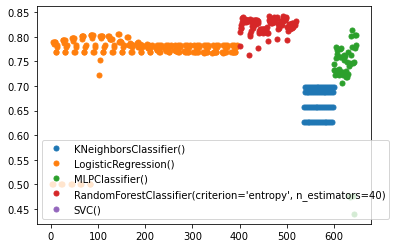

In [21]:
result_table= pd.DataFrame()
result_table['classifier'] = list(map(str, clf.cv_results_['param_classifier'].data))
result_table['mean_score'] = clf.cv_results_['mean_test_score']
groups = result_table.groupby(['classifier'])
for name, group in groups:
     plt.plot(group.index, np.array(group.mean_score), marker='o', linestyle='', markersize=5, label=name)
plt.legend()

In [22]:
for name, group in groups:
    print(name)
    print(np.mean(group.mean_score))

KNeighborsClassifier()
0.6675724792719301
LogisticRegression()
0.7674927756819675
MLPClassifier()
0.7284799046693148
RandomForestClassifier(criterion='entropy', n_estimators=40)
0.8241189407394587
SVC()
nan


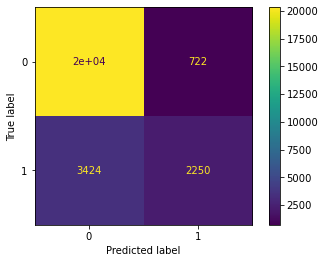

In [23]:
plot_confusion_matrix(clf.best_estimator_,norm_scaled_and_nan_filled_with_mean_and_random,train_labels1)

In [25]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,310,10)),
    'classifier__max_features' : list(range(6,62,5)),
    'classifier__max_features':['sqrt', 'log2'],
    'classifier__criterion':['gini', 'entropy']}
]
clf = GridSearchCV(pipe,param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1 ,scoring='roc_auc')
clf.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:1000,25:], train_labels1.iloc[:1000])
print("BEST PARAMETERS FOR H1N1")
print(clf.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
BEST PARAMETERS FOR H1N1
{'classifier': RandomForestClassifier(criterion='entropy', n_estimators=180), 'classifier__criterion': 'entropy', 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 180}


### Best Parameters for SEASONAL

In [26]:
pipe = Pipeline([('classifier' , RandomForestClassifier())])
param_grid = [
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,310,10)),
    'classifier__max_features' : list(range(6,62,5)),
    'classifier__max_features':['sqrt', 'log2'],
    'classifier__criterion':['gini', 'entropy']}
]
clf = GridSearchCV(pipe,param_grid = param_grid, cv = 5, verbose=2, n_jobs=-1 ,scoring='roc_auc')
clf.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:1000,25:], train_labels2.iloc[:1000])
print("BEST PARAMETERS FOR SEASONAL")
print(clf.best_params_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
BEST PARAMETERS FOR SEASONAL
{'classifier': RandomForestClassifier(), 'classifier__criterion': 'gini', 'classifier__max_features': 'sqrt', 'classifier__n_estimators': 100}


### Finding Best Parameters Using XGBoost

#### for H1N1

In [27]:
xgb = XGBClassifier(use_label_encoder=False,eval_metric='auc')

params = {
        'learning_rate': [0.01, 0.1],
        'min_child_weight' : range(0, 10, 3),
        'max_depth': [3,10,15],
        'n_estimators': range(100,1001,200),  
        'gamma': [0,0.1,1],
        'subsample':[0.6,0.8,1],
        }

gs = GridSearchCV(xgb, param_grid=params, scoring="roc_auc", n_jobs=-1, cv=5, return_train_score=True,verbose=10)

gs.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:1000,25:], train_labels1.iloc[:1000])

print('\n Best hyperparameters for H1N1 vaccine:')
print(gs.best_params_)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

 Best hyperparameters for H1N1 vaccine:
{'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500, 'subsample': 0.6}


#### for Seasonal

In [28]:
xgb = XGBClassifier(use_label_encoder=False,eval_metric='auc')

params = {
        'learning_rate': [0.01, 0.1],
        'min_child_weight' : range(0, 10, 3),
        'max_depth': [3,10,15],
        'n_estimators': range(100,1001,200),  
        'gamma': [0,0.1,1],
        'subsample':[0.6,0.8,1],
        }

gs = GridSearchCV(xgb, param_grid=params, scoring="roc_auc", n_jobs=-1, cv=5, return_train_score=True,verbose=10)

gs.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:1000,25:], train_labels2.iloc[:1000])

print('\n Best hyperparameters for Seasonal Vaccine:')
print(gs.best_params_)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits

 Best hyperparameters for Seasonal Vaccine:
{'gamma': 0.1, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 700, 'subsample': 0.6}


## RandomForest vs XGBoost 

##### RandomForest Scores

In [33]:
rf_model = RandomForestClassifier(criterion= 'entropy', max_features='sqrt', n_estimators=180) 

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:,25:], train_labels1.iloc[:])
scores = []
for k, (train, test) in enumerate(kfold):
    rf_model.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[train, 25:], train_labels1.iloc[train])
    y_pred_proba = rf_model.predict_proba(norm_scaled_and_nan_filled_with_mean_and_random.iloc[test, 25:])
    score = roc_auc_score(train_labels1.iloc[test], y_pred_proba[:, 1])
    scores.append(score)
    print(score)

print("Best RANDOMFOREST auc score for H1N1: ", np.mean(scores))

0.8699407695763843
0.8600612086828817
0.8524901757633063
0.861574343828066
0.8549079785417211
0.8626053156791438
0.873739225653493
0.8679303355163238
0.8525705697999248
0.8459725377620448
Best RANDOMFOREST auc score for H1N1:  0.8601792460803288


In [30]:
rf_model = RandomForestClassifier(criterion= 'gini', max_features='sqrt', n_estimators=100) 

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(norm_scaled_and_nan_filled_with_mean_and_mod.iloc[:,25:], train_labels2.iloc[:])
scores = []
for k, (train, test) in enumerate(kfold):
    rf_model.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[train, 25:], train_labels2.iloc[train])
    y_pred_proba = rf_model.predict_proba(norm_scaled_and_nan_filled_with_mean_and_random.iloc[test, 25:])
    score = roc_auc_score(train_labels2.iloc[test], y_pred_proba[:, 1])
    scores.append(score)
    print(score)

print("Best RANDOMFOREST auc score for SEASONAL: ", np.mean(scores))

0.845573869129309
0.8489161151186138
0.8435416417866727
0.856596597092815
0.8471083062751664
0.8511306971430632
0.8624663979251775
0.8554870131883607
0.8543935738805848
0.8530484095658886
Best RANDOMFOREST auc score for SEASONAL:  0.8518262621105652


##### XGBoost Scores

In [35]:
xgb_model = XGBClassifier(use_label_encoder=False,eval_metric='auc',gamma= 0, learning_rate= 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 500, subsample= 0.6)

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:,25:], train_labels1.iloc[:])
scores = []
for k, (train, test) in enumerate(kfold):
    xgb_model.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[train, 25:], train_labels1.iloc[train])
    y_pred_proba = xgb_model.predict_proba(norm_scaled_and_nan_filled_with_mean_and_random.iloc[test, 25:])
    score = roc_auc_score(train_labels1.iloc[test], y_pred_proba[:, 1])
    scores.append(score)
    print(score)

print("XGB auc score for H1N1: ", np.mean(scores))

0.8717685637837729
0.8618190093950551
0.8532517217561578
0.866253691908943
0.8598100131937607
0.8630523631565905
0.8739347042789307
0.8654504650700562
0.8586855428668712
0.8415767849909553
XGB auc score for H1N1:  0.8615602860401094


In [34]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='auc', gamma= 0.1, learning_rate= 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 700, subsample= 0.6)

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:,25:], train_labels2.iloc[:])
scores = []
for k, (train, test) in enumerate(kfold):
    xgb_model.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[train, 25:], train_labels2.iloc[train])
    y_pred_proba = xgb_model.predict_proba(norm_scaled_and_nan_filled_with_mean_and_random.iloc[test, 25:])
    score = roc_auc_score(train_labels2.iloc[test], y_pred_proba[:, 1])
    scores.append(score)
    print(score)

print("XGB auc score for SEASONAL: ", np.mean(scores))

0.8541220188799574
0.8593014438277323
0.8504096467529072
0.8669966223295785
0.8567301040791172
0.8605865970252164
0.867868924305482
0.8612634396629535
0.8626212888884128
0.8589119390943878
XGB auc score for SEASONAL:  0.8598812024845743


In [79]:
train_features_copy = train_features.copy()

num_cols = train_features_copy.select_dtypes('number').columns
cat_cols = ['race', 'sex',
            'marital_status', 'rent_or_own', 'hhs_geo_region',
            'census_msa', 'employment_industry', 'employment_occupation']
ord_cols = ['age_group', 'education', 'income_poverty',
            'employment_status']

# Impute train
for col in num_cols:
    train_features_copy[col] = train_features_copy[col].fillna(value=-1)
for col in (cat_cols + ord_cols):
    train_features_copy[col] = train_features_copy[col].fillna(value='missing')

le = LabelEncoder()

for feat in categorical_features:
    train_features_copy[feat] = le.fit_transform(train_features_copy[feat].astype(str))

import xgboost as xgb
xgr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.6063545543520819, gamma=1.5160109364510506,
        importance_type='gain', learning_rate=0.01, max_delta_step=0,
        max_depth=12, min_child_weight=8, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
        reg_alpha=0, reg_lambda=0.4994303428476974, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1)

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(train_features_copy, train_labels1)
scores = []
for k, (train, test) in enumerate(kfold):
    xgr.fit(train_features_copy.iloc[train], train_labels1.iloc[train])
    y_pred1 = xgr.predict(train_features_copy.iloc[test])
    score = roc_auc_score(train_labels1.iloc[test], y_pred1)
    scores.append(score)
    print(score)

print("XGR auc score for H1N1: ", np.mean(scores))

0.8710208488408742
0.8636929071022861
0.8556704790069809
0.86810801805603
0.8605471392310113
0.8670686745293444
0.8759384648356138
0.8679370446686978
0.8627475153073505
0.847001973329442
XGR auc score for H1N1:  0.8639733064907631


In [82]:
import xgboost as xgb
xgr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.6063545543520819, gamma=1.5160109364510506,
        importance_type='gain', learning_rate=0.01, max_delta_step=0,
        max_depth=12, min_child_weight=8, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
        reg_alpha=0, reg_lambda=0.4994303428476974, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1)

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(train_features_copy, train_labels2)
scores = []
for k, (train, test) in enumerate(kfold):
    xgr.fit(train_features_copy.iloc[train], train_labels2.iloc[train])
    y_pred2 = xgr.predict(train_features_copy.iloc[test])
    score = roc_auc_score(train_labels2.iloc[test], y_pred2)
    scores.append(score)
    print(score)

print("XGR auc score for Seasonal: ", np.mean(scores))

0.8533608938346056
0.8589175010309836
0.8497928106769536
0.8657601335745848
0.8549286047449622
0.8591016838779892
0.8696839433344523
0.8612073441686902
0.8610748573229425
0.8590430165056059
XGR auc score for Seasonal:  0.8592870789071771


# Test Prediction and Submission

In [36]:
test_features = pd.read_csv('./test_set_features.csv', index_col='respondent_id')

test_data_nan_filled_with_mean_and_random = test_features.copy()

for col in numeric_cols:
    test_data_nan_filled_with_mean_and_random[col].fillna((test_data_nan_filled_with_mean_and_random[col].mean()), inplace=True)
for c in categorical_features:
    cleanedList = [x for x in test_data_nan_filled_with_mean_and_random[c] if str(x) != 'nan']  
    test_data_nan_filled_with_mean_and_random[c].fillna(random.choice(cleanedList), inplace=True)

X_hot_code = test_data_nan_filled_with_mean_and_random.copy()
X_hot_code = pd.get_dummies(X_hot_code, columns=categorical_features)
test_data_nan_filled_with_mean_and_random = test_data_nan_filled_with_mean_and_random.drop(categorical_features,axis=1)
test_data_nan_filled_with_mean_and_random = pd.concat([test_data_nan_filled_with_mean_and_random,X_hot_code], axis=1)

test_data_nan_filled_with_mean_and_random = test_data_nan_filled_with_mean_and_random.set_axis([str(x) for x in list(range(128))], axis=1)

In [73]:
"""model1 = XGBClassifier(use_label_encoder=False,eval_metric='auc', gamma= 0, learning_rate= 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 500, subsample= 0.6, reg_lambda= 1)
model1.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:,25:], train_labels1.iloc[:])
y_pred_proba1 = model1.predict_proba(test_data_nan_filled_with_mean_and_random.iloc[:,25:])

model2 = XGBClassifier(use_label_encoder=False,eval_metric='auc', gamma= 0.1, learning_rate= 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 700, subsample= 0.6, reg_lambda= 1) 
model2.fit(norm_scaled_and_nan_filled_with_mean_and_random.iloc[:,25:], train_labels2.iloc[:])
y_pred_proba2 = model2.predict_proba(test_data_nan_filled_with_mean_and_random.iloc[:,25:])"""

"""model1 = XGBClassifier(use_label_encoder=False,eval_metric='auc', gamma= 0, learning_rate= 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 500, subsample= 0.6, reg_lambda= 1)
model1.fit(norm_scaled_and_nan_filled_with_mean_and_random, train_labels1)
y_pred_proba1 = model1.predict_proba(test_data_nan_filled_with_mean_and_random)

model2 = XGBClassifier(use_label_encoder=False,eval_metric='auc', gamma= 0.1, learning_rate= 0.01, max_depth= 3, min_child_weight= 6, n_estimators= 700, subsample= 0.6, reg_lambda= 1) 
model2.fit(norm_scaled_and_nan_filled_with_mean_and_random, train_labels2)
y_pred_proba2 = model2.predict_proba(test_data_nan_filled_with_mean_and_random) 0.7622"""
train_features_copy = train_features.copy()
test_features_copy = test_features.copy()
num_cols = train_features_copy.select_dtypes('number').columns

cat_cols = ['race', 'sex',
            'marital_status', 'rent_or_own', 'hhs_geo_region',
            'census_msa', 'employment_industry', 'employment_occupation']

ord_cols = ['age_group', 'education', 'income_poverty',
            'employment_status']

# Impute train
for col in num_cols:
    train_features_copy[col] = train_features_copy[col].fillna(value=-1)
for col in (cat_cols + ord_cols):
    train_features_copy[col] = train_features_copy[col].fillna(value='missing')
for col in num_cols:
    test_features_copy[col] = test_features_copy[col].fillna(value=-1)
for col in (cat_cols + ord_cols):
    test_features_copy[col] = test_features_copy[col].fillna(value='missing')

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

for feat in categorical_features:
    train_features_copy[feat] = le.fit_transform(train_features_copy[feat].astype(str))
for feat in categorical_features:
    test_features_copy[feat] = le.fit_transform(test_features_copy[feat].astype(str))

import xgboost as xgb
xgr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.6063545543520819, gamma=1.5160109364510506,
        importance_type='gain', learning_rate=0.01, max_delta_step=0,
        max_depth=12, min_child_weight=8, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
        reg_alpha=0, reg_lambda=0.4994303428476974, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1)

xgr.fit(train_features_copy, train_labels1)
y_pred_proba1 = xgr.predict(test_features_copy)

xgr.fit(train_features_copy, train_labels2)
y_pred_proba2 = xgr.predict(test_features_copy)

In [74]:
df = pd.DataFrame()
df['respondent_id'] = test_features.index.values
df['h1n1_vaccine'] = y_pred_proba1
df['seasonal_vaccine'] = y_pred_proba2
df

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,26707,0.309961,0.359308
1,26708,0.206761,0.233983
2,26709,0.323429,0.626841
3,26710,0.507886,0.722683
4,26711,0.416430,0.522142
...,...,...,...
26703,53410,0.336896,0.475066
26704,53411,0.237814,0.426299
26705,53412,0.274444,0.397711
26706,53413,0.212768,0.448330


In [75]:
df.to_csv("results-7.csv", encoding='utf-8',index = False)